### Using Neural Networks

Imports

In [1]:
# conda install -c pytorch torchvision 

In [2]:
## imports

import time
import numpy as np
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, random_split
from torchvision import datasets
from torchvision import transforms
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve

In [3]:
# loading the dataset

df = pd.read_csv('data/archive.zip')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
df.shape

(303, 14)

In [5]:
## getting the features

X = df.drop(labels='target', axis=1)
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


In [6]:
## labels 
y = df['target']

In [7]:
## splitting training and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((272, 13), (31, 13), (272,), (31,))

In [8]:
## scaling the continuous features

numerical_features = ['age', 'trestbps', "chol", "thalach", "oldpeak"]

numeric_transformer = Pipeline(steps= [
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features)
        ], remainder='passthrough')

In [9]:
## scaled features

X_transform = preprocessor.fit_transform(X_train)

In [10]:
## Converting dataset to tensor

X_train_tnsr = torch.tensor(X_transform, dtype=torch.float32)
y_train_tnsr = torch.tensor(np.array(y_train))

In [11]:
# looking at the data type
y_train_tnsr.dtype

torch.int64

In [12]:
## Scaling the test set

X_test_transform = preprocessor.transform(X_test)

In [13]:
## Converting dataset to tensor

X_test_tnsr = torch.tensor(X_test_transform, dtype=torch.float32)
y_test_tnsr = torch.tensor(np.array(y_test))

Model Settings 

In [14]:
## Hyper-parameters

LEARNING_RATE = 0.001
NUM_EPOCHS = 500

NUM_FEATURES = 13
NUM_CLASSES = 2

In [15]:
### model

class MLP(nn.Module):
    def __init__(self, in_features, num_classes):
        super(MLP, self).__init__()
        
        self.num_classes = num_classes
        self.in_features = in_features
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=self.in_features, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=num_classes))
        
    def forward(self, X):
        logits = self.classifier(X)
        probas = F.softmax(logits, dim=1)
        return logits, probas
    
    def predict_(self, X):
        logits, probas = self.forward(X)
        predictions = torch.where(probas > .5, torch.tensor([1]), torch.tensor([0]))
        predictions = torch.argmax(predictions, dim=1)
        return predictions     
    
    def accuracy(self, X, y):
        predictions = self.predict_(X)
        total_correct = predictions == y
        return torch.true_divide(torch.sum(total_correct), total_correct.size(0))

In [16]:
## Model initialization

model = MLP(in_features=NUM_FEATURES, num_classes=NUM_CLASSES)

## optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [17]:
## Compute loss

def compute_loss(model, features, targets):
    curr_loss = 0
    with torch.no_grad():
        logits, probas = model(features)
        loss = F.cross_entropy(logits, targets)
        curr_loss += loss
    return float(curr_loss)/features.size(0)

In [18]:
## train the model 
## We only have small amount of datasets so we will train them all in one batch

features = X_train_tnsr
targets = y_train_tnsr

start_time = time.time()
epoch_cost = []
for epoch in range(NUM_EPOCHS):
    model.train()


    # forward prop and back prop
    logits, probas = model(features)

    cost = F.cross_entropy(logits, targets)
    optimizer.zero_grad()

    cost.backward()

    optimizer.step()

    
    cost = compute_loss(model, X_train_tnsr, y_train_tnsr)
    epoch_cost.append(cost)
    if epoch % 50 == 0:
        print(f"Epoch: {epoch+1:03d}/{NUM_EPOCHS} Train cost: {cost:.4f}")
        print(f"Time elapsed: {(time.time() - start_time)/60:.2f}min")

Epoch: 001/500 Train cost: 0.0024
Time elapsed: 0.00min
Epoch: 051/500 Train cost: 0.0009
Time elapsed: 0.00min
Epoch: 101/500 Train cost: 0.0002
Time elapsed: 0.01min
Epoch: 151/500 Train cost: 0.0000
Time elapsed: 0.01min
Epoch: 201/500 Train cost: 0.0000
Time elapsed: 0.01min
Epoch: 251/500 Train cost: 0.0000
Time elapsed: 0.01min
Epoch: 301/500 Train cost: 0.0000
Time elapsed: 0.02min
Epoch: 351/500 Train cost: 0.0000
Time elapsed: 0.02min
Epoch: 401/500 Train cost: 0.0000
Time elapsed: 0.02min
Epoch: 451/500 Train cost: 0.0000
Time elapsed: 0.03min


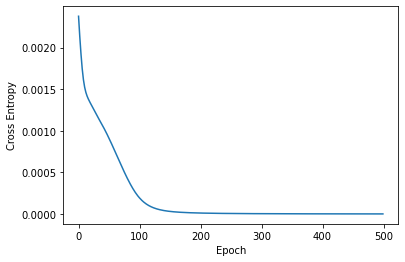

In [19]:
## Plotting the cost

plt.plot(epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

In [20]:
## predicting the labels 

predictions = model.predict_(X_test_tnsr[:5,:])
true_labels = y_test_tnsr[:5]

print(f"Predictions {predictions} \nTrue labels {true_labels}")

Predictions tensor([0, 0, 0, 1, 0]) 
True labels tensor([0, 0, 0, 1, 0])


In [21]:
### measuring the accuracy

model.accuracy(X_test_tnsr, y_test_tnsr)

tensor(0.8387)

In [22]:
### Evaluating the model confusion matrix


predictions_for_transformed = model.predict_(X_test_tnsr)


cm = confusion_matrix(y_test_tnsr, predictions_for_transformed)

print(f"Model accuracy of Neural network: {accuracy_score(y_test, predictions_for_transformed)*100:.2f}%\n")
print(f"Confusion matrix:\n {cm}")
print(classification_report(y_test, predictions_for_transformed))

Model accuracy of Neural network: 83.87%

Confusion matrix:
 [[11  3]
 [ 2 15]]
              precision    recall  f1-score   support

           0       0.85      0.79      0.81        14
           1       0.83      0.88      0.86        17

    accuracy                           0.84        31
   macro avg       0.84      0.83      0.84        31
weighted avg       0.84      0.84      0.84        31



In [23]:
_, predictions = model(X_test_tnsr)
y_probabilities = predictions[:,1].detach().numpy()

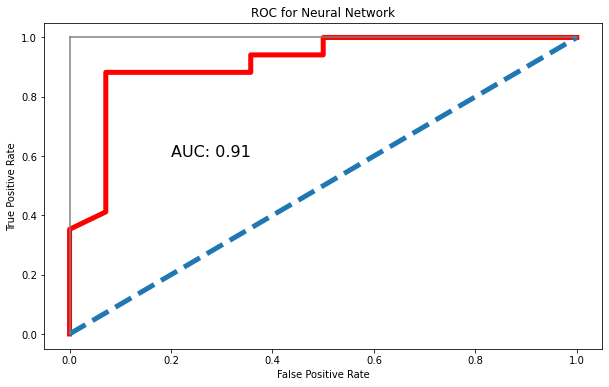

In [24]:
false_positive_rate_nn, true_positive_rate_nn, threshold_nn = roc_curve(y_test,y_probabilities)

#Plotting ROC Curve
plt.figure(figsize=(10,6))
plt.title('ROC for Neural Network')
plt.plot(false_positive_rate_nn, true_positive_rate_nn, linewidth=5, color='red')
plt.plot([0,1],ls='--',linewidth=5)
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.text(0.2,0.6,'AUC: {:.2f}'.format(roc_auc_score(y_test,y_probabilities)),size= 16)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [25]:
## Adding dropout to see how it effects the performance

### model

class MLP_(nn.Module):
    def __init__(self, in_features, num_classes):
        super(MLP_, self).__init__()
        
        self.num_classes = num_classes
        self.in_features = in_features
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=self.in_features, out_features=256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=128, out_features=num_classes))
        
    def forward(self, X):
        logits = self.classifier(X)
        probas = F.softmax(logits, dim=1)
        return logits, probas
    
    def predict_(self, X):
        logits, probas = self.forward(X)
        predictions = torch.where(probas > .5, torch.tensor([1]), torch.tensor([0]))
        predictions = torch.argmax(predictions, dim=1)
        return predictions     
    
    def accuracy(self, X, y):
        predictions = self.predict_(X)
        total_correct = predictions == y
        return torch.true_divide(torch.sum(total_correct), total_correct.size(0))

In [26]:
## Model initialization

model_dropout = MLP_(in_features=NUM_FEATURES, num_classes=NUM_CLASSES)

## optimizer
optimizer = torch.optim.Adam(model_dropout.parameters(), lr=LEARNING_RATE)

## train the model 
## We only have small amount of datasets so we will train them all in one batch

features = X_train_tnsr
targets = y_train_tnsr

start_time = time.time()
epoch_cost = []
for epoch in range(NUM_EPOCHS):
    model_dropout.train()


    # forward prop and back prop
    logits, probas = model_dropout(features)

    cost = F.cross_entropy(logits, targets)
    optimizer.zero_grad()

    cost.backward()

    optimizer.step()

    
    cost = compute_loss(model_dropout, X_train_tnsr, y_train_tnsr)
    epoch_cost.append(cost)
    if epoch % 50 == 0:
        print(f"Epoch: {epoch+1:03d}/{NUM_EPOCHS} Train cost: {cost:.4f}")
        print(f"Time elapsed: {(time.time() - start_time)/60:.2f}min")

Epoch: 001/500 Train cost: 0.0024
Time elapsed: 0.00min
Epoch: 051/500 Train cost: 0.0013
Time elapsed: 0.01min
Epoch: 101/500 Train cost: 0.0010
Time elapsed: 0.01min
Epoch: 151/500 Train cost: 0.0008
Time elapsed: 0.01min
Epoch: 201/500 Train cost: 0.0007
Time elapsed: 0.02min
Epoch: 251/500 Train cost: 0.0005
Time elapsed: 0.02min
Epoch: 301/500 Train cost: 0.0006
Time elapsed: 0.03min
Epoch: 351/500 Train cost: 0.0003
Time elapsed: 0.03min
Epoch: 401/500 Train cost: 0.0003
Time elapsed: 0.04min
Epoch: 451/500 Train cost: 0.0002
Time elapsed: 0.05min


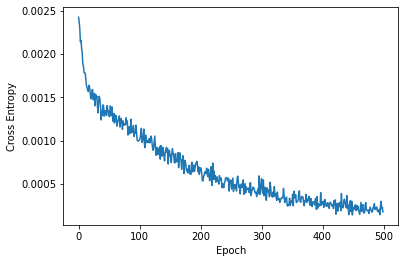

In [27]:
## Plotting the cost

plt.plot(epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

In [28]:
### Evaluating the model confusion matrix

## Dropout improved the performance by ~3%


predictions = model_dropout.predict_(X_test_tnsr)


cm = confusion_matrix(y_test_tnsr, predictions)

print(f"Model accuracy of Neural network: {accuracy_score(y_test, predictions)*100:.2f}%\n")
print(f"Confusion matrix:\n {cm}")
print(classification_report(y_test, predictions))

Model accuracy of Neural network: 87.10%

Confusion matrix:
 [[12  2]
 [ 2 15]]
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        14
           1       0.88      0.88      0.88        17

    accuracy                           0.87        31
   macro avg       0.87      0.87      0.87        31
weighted avg       0.87      0.87      0.87        31



In [29]:
_, predictions = model_dropout(X_test_tnsr)
y_probabilities = predictions[:,1].detach().numpy()

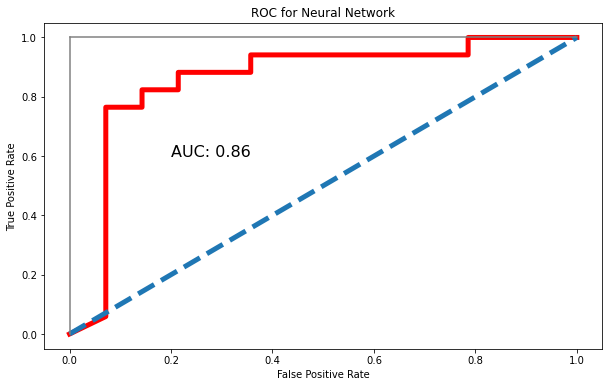

In [30]:
false_positive_rate_nn, true_positive_rate_nn, threshold_nn = roc_curve(y_test,y_probabilities)

#Plotting ROC Curve
plt.figure(figsize=(10,6))
plt.title('ROC for Neural Network')
plt.plot(false_positive_rate_nn, true_positive_rate_nn, linewidth=5, color='red')
plt.plot([0,1],ls='--',linewidth=5)
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.text(0.2,0.6,'AUC: {:.2f}'.format(roc_auc_score(y_test,y_probabilities)),size= 16)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [31]:
## Adding batch norm to see how it effects the performance

### model

class MLP_(nn.Module):
    def __init__(self, in_features, num_classes):
        super(MLP_, self).__init__()
        
        self.num_classes = num_classes
        self.in_features = in_features
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=self.in_features, out_features=256),
            nn.BatchNorm1d(num_features=256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=256, out_features=128),
            nn.BatchNorm1d(num_features=128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=128, out_features=num_classes))
        
    def forward(self, X):
        logits = self.classifier(X)
        probas = F.softmax(logits, dim=1)
        return logits, probas
    
    def predict_(self, X):
        logits, probas = self.forward(X)
        predictions = torch.where(probas > .5, torch.tensor([1]), torch.tensor([0]))
        predictions = torch.argmax(predictions, dim=1)
        return predictions     
    
    def accuracy(self, X, y):
        predictions = self.predict_(X)
        total_correct = predictions == y
        return torch.true_divide(torch.sum(total_correct), total_correct.size(0))

In [32]:
### Adding regularization to the same model to see if the generalization performance increases

## Model initialization

model_dropout_batchnorm = MLP_(in_features=NUM_FEATURES, num_classes=NUM_CLASSES)

## optimizer
optimizer = torch.optim.Adam(model_dropout_batchnorm.parameters(), lr=LEARNING_RATE, weight_decay=0)

## train the model 
## We only have small amount of datasets so we will train them all in one batch

features = X_train_tnsr
targets = y_train_tnsr

start_time = time.time()
epoch_cost = []
for epoch in range(NUM_EPOCHS):
    model_dropout_batchnorm.train()


    # forward prop and back prop
    logits, probas = model_dropout_batchnorm(features)

    cost = F.cross_entropy(logits, targets)
    optimizer.zero_grad()

    cost.backward()

    optimizer.step()

    
    cost = compute_loss(model_dropout_batchnorm, X_train_tnsr, y_train_tnsr)
    epoch_cost.append(cost)
    if epoch % 50 == 0:
        print(f"Epoch: {epoch+1:03d}/{NUM_EPOCHS} Train cost: {cost:.4f}")
        print(f"Time elapsed: {(time.time() - start_time)/60:.2f}min")

Epoch: 001/500 Train cost: 0.0025
Time elapsed: 0.00min
Epoch: 051/500 Train cost: 0.0011
Time elapsed: 0.02min
Epoch: 101/500 Train cost: 0.0009
Time elapsed: 0.04min
Epoch: 151/500 Train cost: 0.0007
Time elapsed: 0.06min
Epoch: 201/500 Train cost: 0.0005
Time elapsed: 0.08min
Epoch: 251/500 Train cost: 0.0004
Time elapsed: 0.10min
Epoch: 301/500 Train cost: 0.0004
Time elapsed: 0.12min
Epoch: 351/500 Train cost: 0.0004
Time elapsed: 0.14min
Epoch: 401/500 Train cost: 0.0002
Time elapsed: 0.18min
Epoch: 451/500 Train cost: 0.0003
Time elapsed: 0.22min


In [33]:
### Evaluating the model confusion matrix

## Adding Batchnorm improved the performance by ~5%


predictions = model_dropout_batchnorm.predict_(X_test_tnsr)


cm = confusion_matrix(y_test_tnsr, predictions)

print(f"Model accuracy of Neural network: {accuracy_score(y_test, predictions)*100:.2f}%\n")
print(f"Confusion matrix:\n {cm}")
print(classification_report(y_test, predictions))

Model accuracy of Neural network: 83.87%

Confusion matrix:
 [[10  4]
 [ 1 16]]
              precision    recall  f1-score   support

           0       0.91      0.71      0.80        14
           1       0.80      0.94      0.86        17

    accuracy                           0.84        31
   macro avg       0.85      0.83      0.83        31
weighted avg       0.85      0.84      0.84        31



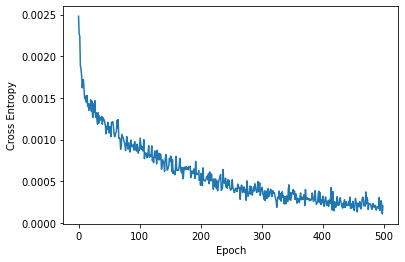

In [34]:
## Plotting the cost

plt.plot(epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

In [35]:
_, predictions = model_dropout_batchnorm(X_test_tnsr)

In [36]:
y_probabilities = predictions[:,1].detach().numpy()

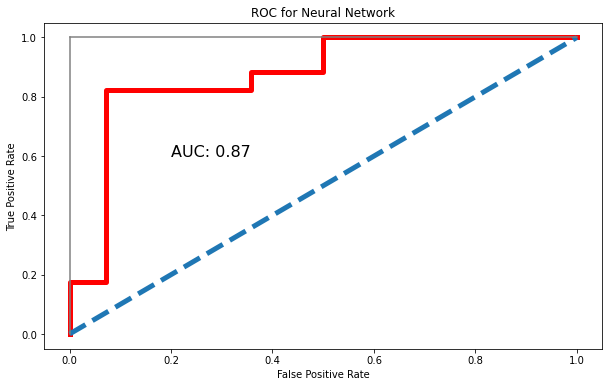

In [37]:
false_positive_rate_nn, true_positive_rate_nn, threshold_nn = roc_curve(y_test,y_probabilities)

#Plotting ROC Curve
plt.figure(figsize=(10,6))
plt.title('ROC for Neural Network')
plt.plot(false_positive_rate_nn, true_positive_rate_nn, linewidth=5, color='red')
plt.plot([0,1],ls='--',linewidth=5)
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.text(0.2,0.6,'AUC: {:.2f}'.format(roc_auc_score(y_test,y_probabilities)),size= 16)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [40]:
true_positive_rate_nn

array([0.        , 0.05882353, 0.17647059, 0.17647059, 0.82352941,
       0.82352941, 0.88235294, 0.88235294, 1.        , 1.        ])

In [41]:
false_positive_rate_nn

array([0.        , 0.        , 0.        , 0.07142857, 0.07142857,
       0.35714286, 0.35714286, 0.5       , 0.5       , 1.        ])

In [61]:
## accuracy in training set 

model_dropout_batchnorm.accuracy(X_train_tnsr, y_train_tnsr).item() * 100 

98.16176295280457